In [2]:
# Standard imports
import sys
sys.path.append("../../")
import time
import gc

# 3rd party imports
import numpy as np 
import matplotlib.pyplot as plt 
import nibabel as nib
from tqdm import tqdm 
from scipy.sparse.linalg import lgmres
import scipy 
# Our libraries


Laplacian setup

In [3]:
def remove_duplicates(list1: np.ndarray, list2: np.ndarray):
    """
    Remove duplicate elements from list1 and the corresponding elements from list2.
    
    Parameters:
    - list1: The first list from which duplicates will be removed.
    - list2: The second list from which elements will be removed corresponding to the removed elements in list1.
    
    Returns:
    - list1_unique: The list1 with duplicates removed.
    - list2_filtered: The list2 with elements removed corresponding to the removed elements in list1.
    """
    seen = set()
    list1_unique = []
    list2_filtered = []
    
    for item1, item2 in zip(list1, list2):
        item1_tuple = tuple(item1)
        if item1_tuple not in seen:
            seen.add(item1_tuple)
            list1_unique.append(item1)
            list2_filtered.append(item2)
    
    return np.array(list1_unique), np.array(list2_filtered)


def loadNiiImages(imageList, scale = False):
    """
    imageList can contaiin both paths to .nii images or loaded nii images
    loads nii images from the paths provided in imageList and returns a list of 3D numpy array representing image data. 
    If numpy data is present in imageList, the same will be returned 
    """
    if scale:
        if type(imageList[0])==str:
            fImage = nib.load(imageList[0])
        else:
            scale = False

    images =[]
    for image in imageList:
        if type(image) == str:
            niiImage = nib.load(image)
            imdata = niiImage.get_fdata()

            # Execution is faster on copied data
            if scale:
                scales = tuple(np.array(niiImage.header.get_zooms()) / np.array(fImage.header.get_zooms()))

                imdata =  scipy.ndimage.zoom(imdata.copy(), scales, order=1)
            images.append(imdata.copy())

        else:
            images.append(image.copy()) 

    if (len(imageList)==1):
        return images[0]
    return images


def laplacianA3D(shape, boundaryIndices):
    """
    Creates the matrix A that correspond to the linear system of ewuations used to perform laplacian Interpolation on 3D volume images

    Parameters
    --------------
    shape : tuple 3D shape
    boundaryIndices : indices of boundary points when flattened. If (x,y) is pixel x*shape[1]*shape[2]+y*shape[2]+z will be flattened index. 
    """
    k = len(shape)
    # Create X,Y,Z arrays that represent the x,y,z indices of each voxel
    X,Y,Z = np.meshgrid(range(shape[0]), range(shape[1]), range(shape[2]), indexing='ij')

    X=X.flatten().astype(int)
    Y=Y.flatten().astype(int)
    Z=Z.flatten().astype(int)

    # Calculate each voxel's index when flattened
    ids_0  = X* shape[1]*shape[2] + Y*shape[2]+ Z
    data  = np.ones(len(ids_0)) * 2*k
    boundaryIndices = boundaryIndices.astype(int)

    """
    rids: row indices value
    cids: column indices values
    data: Diagonal entries of sparse matrix A. A[rid, rid] = 6 at all non boundary locations. 
          A[rid, rid] = 1 at Dirchlet boundary. A[rid, rid] = number of valid neighbours at volume boundary


    """
    print("Building data for Laplacian Sparse Matrix A")

    # Calculate the voxel index of (x-1,y,z) for each (x,y,z)
    cids_x1  = (X-1)* shape[1]*shape[2] + Y*shape[2]+ Z
    invalid_cx1 = np.concatenate([np.where(X==0)[0], boundaryIndices])  # invalid column indices and coorespondences indices. X==0 is invalid because X-1 will be negative
    rids_x1  = np.delete(ids_0, invalid_cx1) # remove invalid row indices that correspond to column
    cids_x1  = np.delete(cids_x1, invalid_cx1) # remove invalid column indices
    data[invalid_cx1] -=1   # decrease the value of A[rid, rid] by 1 at invalid indices

    # Calculate the voxel index of (x+1,y,z) for each (x,y,z)
    cids_x2  = (X+1)* shape[1]*shape[2] + Y*shape[2]+ Z
    invalid_cx2 = np.concatenate([np.where(X==shape[0] -1 )[0], boundaryIndices])
    rids_x2  = np.delete(ids_0, invalid_cx2)
    cids_x2  = np.delete(cids_x2, invalid_cx2)
    data[invalid_cx2] -=1

    # Calculate the voxel index of (x,y-1,z) for each (x,y,z)
    cids_y1  = X* shape[1]*shape[2] + (Y-1)*shape[2]+ Z
    invalid_cy1 = np.concatenate([np.where(Y==0)[0], boundaryIndices])
    rids_y1  = np.delete(ids_0, invalid_cy1)
    cids_y1  = np.delete(cids_y1, invalid_cy1)
    data[invalid_cy1] -=1

    # Calculate the voxel index of (x,y+1,z) for each (x,y,z)
    cids_y2  = X* shape[1]*shape[2] + (Y+1)*shape[2]+ Z
    invalid_cy2 = np.concatenate([np.where(Y==shape[1]-1)[0], boundaryIndices])
    rids_y2  = np.delete(ids_0, invalid_cy2)
    cids_y2  = np.delete(cids_y2, invalid_cy2)
    data[invalid_cy2] -=1

    # Calculate the voxel index of (x,y,z-1) for each (x,y,z)
    cids_z1  = X* shape[1]*shape[2] + Y*shape[2]+ Z-1
    invalid_cz1 = np.concatenate([np.where(Z==0)[0], boundaryIndices])
    rids_z1  = np.delete(ids_0, invalid_cz1)
    cids_z1  = np.delete(cids_z1, invalid_cz1)
    data[invalid_cz1] -=1

    # Calculate the voxel index of (x,y,z+1) for each (x,y,z)
    cids_z2  = X* shape[1]*shape[2] +Y*shape[2]+ Z+1
    invalid_cz2 = np.concatenate([np.where(Z==shape[2] - 1)[0], boundaryIndices])   
    rids_z2  = np.delete(ids_0, invalid_cz2)  
    cids_z2  = np.delete(cids_z2, invalid_cz2) 
    data[invalid_cz2] -=1 

    # Diagonal entries corresponding to dirichlet boundaries should be 1
    data[boundaryIndices] +=1

    rowx = np.hstack([ids_0, rids_x1, rids_x2,rids_y1,rids_y2, rids_z1, rids_z2])
    rowy = np.hstack([ids_0, cids_x1, cids_x2,cids_y1,cids_y2, cids_z1, cids_z2])
    rowv = np.hstack([data , -1*np.ones(rowx.shape[0] - ids_0.shape[0]) ] )

    print("Creating Laplacian Sparse Matrix A")
    A = scipy.sparse.csr_matrix((rowv,(rowx,rowy)), shape =(X.shape[0],X.shape[0]))
    del rowx, rowy, rowv, X, Y,Z, data
    gc.collect()

    return A


def sliceToSlice3DLaplacian(fixedImage, mpoints, fpoints):
    """
    Assumes both the images are matched slice to slice according to sliceMatchList along axis- 'axis'
    Gets 2D correspondences between the slices and interpolates them smoothly across the volume
    """
    print("Loading fixed image")
    fdata = loadNiiImages([fixedImage])
    print("Loaded fixed image")
    
    nx, ny, nz  = fdata.shape
    nd  = len(fdata.shape)
    print("fdata.shape", fdata.shape)
    
    deformationField = np.zeros((nd, nx, ny, nz))
    
    flen  = nx*ny*nz
    Xcount = np.zeros(flen)
    Ycount = np.zeros(flen)
    Zcount = np.zeros(flen)

    Xd =  np.zeros(flen)
    Yd =  np.zeros(flen)
    Zd =  np.zeros(flen)

    fIndices = fpoints[:,0] * ny*nz + fpoints[:,1] * nz + fpoints[:,2]
    fIndices = fIndices.astype(int)
    
    Ycount[fIndices] +=1
    Zcount[fIndices] +=1
    Yd[fIndices] += mpoints[:,1] - fpoints[:,1]
    Zd[fIndices] += mpoints[:,2] - fpoints[:,2]
    
    start = time.time()
    A = laplacianA3D(fdata.shape, Ycount.nonzero()[0])
    #print("Saving to npy")
    #np.save("Laplacian_A.npy", A.toarray())
    #np.save("Yd.npy", Yd)
    #np.save("Zd.npy", Zd)
    print("Computing dy")
    dy = lgmres(A, Yd , tol = 1e-2)[0]
    print("dx calculated in {}s".format(time.time() - start))

    print("Computing dx")
    dz = lgmres(A, Zd, tol = 1e-2)[0]
    print("dz calculated in {}s".format(time.time() - start))

    deformationField[0] = np.zeros(fdata.shape)
    deformationField[1] = dy.reshape(fdata.shape)
    deformationField[2] = dz.reshape(fdata.shape)
    
    return deformationField, A, Yd, Zd

Correspondence processing

In [4]:
def orientation(p, q, r):
    """
    Calculate the orientation of the ordered triplet (p, q, r).
    
    Parameters:
    - p, q, r: Points represented as tuples or lists with two elements (x, y).
    
    Returns:
    - 0 if the points are collinear.
    - 1 if the points form a clockwise orientation.
    - 2 if the points form a counterclockwise orientation.
    """
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0
    return 1 if val > 0 else 2


def on_segment(p, q, r):
    """
    Check if point q lies on the line segment pr.
    
    Parameters:
    - p, q, r: Points represented as tuples or lists with two elements (x, y).
    
    Returns:
    - True if q lies on the line segment pr, False otherwise.
    """
    if min(p[0], r[0]) <= q[0] <= max(p[0], r[0]) and min(p[1], r[1]) <= q[1] <= max(p[1], r[1]):
        return True
    return False


def do_lines_intersect(p1, q1, p2, q2):
    """
    Check if two line segments (p1, q1) and (p2, q2) intersect.
    
    Parameters:
    - p1, q1: Endpoints of the first line segment.
    - p2, q2: Endpoints of the second line segment.
    
    Returns:
    - True if the line segments intersect, False otherwise.
    """
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)
    
    # Special cases (collinear and one endpoint lies on the other line segment)
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True
    
    # Case: one endpoint is an endpoint on another line segment
    if np.array_equal(p1, p2) or np.array_equal(p1, q2) or np.array_equal(q1, p2) or np.array_equal(q1, q2):
        return False
    
    # General case
    if o1 != o2 and o3 != o4:
        return True

    return False

def swap_correspondences(mpts: np.ndarray, fpts: np.ndarray) -> np.ndarray:
    """
    Swap the correspondences of the moving and fixed points if they intersect.
    
    Parameters:
    - mpts: The moving points.
    - fpts: The fixed points.
    
    Returns:
    - swapped_fpts: The swapped fixed points.
    """
    swapped_fpts = np.copy(fpts)
    intersecting_pts = []
    
    for i in range(len(mpts)):
        line_segment1 = (mpts[i], fpts[i])
        for j in range(i + 1, len(mpts)):
            line_segment2 = (mpts[j], fpts[j])
            if do_lines_intersect(line_segment1[0], line_segment1[1], line_segment2[0], line_segment2[1]):
                swapped_fpts[i] = fpts[j]
                swapped_fpts[j] = fpts[i]
                intersecting_pts.append(fpts[i])
                intersecting_pts.append(fpts[j])
                #print(f"Swapped correspondences {i} and {j}")
    return swapped_fpts, intersecting_pts


def detect_intersecting_segments(mpts: np.ndarray, fpts: np.ndarray) -> np.ndarray:
    """
    Detect intersecting line segments in the correspondences.
    
    Parameters:
    - mpts: The moving points.
    - fpts: The fixed points.
    
    Returns:
    - intersecting_indices: The indices of the intersecting line segments.
    - intersecting_segments: The intersecting line segments (points).
    - swapped_segments: The swapped line segments (points).
    """
    intersecting_indices = []
    intersecting_segments = []
    swapped_segments = []
    
    for i in range(len(mpts)):
        line_segment1 = (mpts[i], fpts[i])
        for j in range(i + 1, len(mpts)):
            line_segment2 = (mpts[j], fpts[j])
            # Check if the line segments intersect
            if do_lines_intersect(line_segment1[0], line_segment1[1], line_segment2[0], line_segment2[1]):
                intersecting_indices.append((i, j))
                intersecting_segments.append((line_segment1, line_segment2))
                swapped_segments.append(((mpts[i], fpts[j]), (mpts[j], fpts[i])))
    intersecting_indices = np.array(intersecting_indices)
    return intersecting_indices, intersecting_segments, swapped_segments

Jacobian functions

In [51]:
import SimpleITK as sitk

def sitk_jacobian_determinant(deformation):
    '''
    deformation - 3, X, Y, Z, 3
    '''
    deformation = np.transpose(deformation, [1,2,3,0])
    print("SITK deformation shape:", deformation.shape)
    deformation = deformation[:, :, :, [2,1,0]]
    #print(deformation[350, 200, 200, :])
    sitk_displacement_field = sitk.GetImageFromArray(deformation, isVector=True)
    jacobian_det_volume = sitk.DisplacementFieldJacobianDeterminant(sitk_displacement_field)
    jacobian_det_np_arr = sitk.GetArrayFromImage(jacobian_det_volume)
    #n_count = np.sum(jacobian_det_np_arr < 0)
    return jacobian_det_np_arr



def surrounding_points(coord: tuple, deformation: np.ndarray, jacobian_det: np.ndarray):
    """
    Print out the surrounding points of a specific coordinate in the deformation field
    along with their displacement vectors and Jacobian determinants.
    
    Parameters:
    - coord: The coordinate of the point (z, y, x).
    - deformation: The deformation field (3D vector field).
    - jacobian_det: The Jacobian determinant volume.
    """
    curr_coord = coord
    # Get the coordinates of the surrounding points
    curr_coord_up = (curr_coord[0], curr_coord[1] - 1, curr_coord[2])
    curr_coord_down = (curr_coord[0], curr_coord[1] + 1, curr_coord[2])
    curr_coord_left = (curr_coord[0], curr_coord[1], curr_coord[2] - 1)
    curr_coord_right = (curr_coord[0], curr_coord[1], curr_coord[2] + 1)
    curr_coord_prev = (curr_coord[0] - 1, curr_coord[1], curr_coord[2])
    curr_coord_next = (curr_coord[0] + 1, curr_coord[1], curr_coord[2])

    # Get the displacement vectors
    curr_vector = deformation[:, curr_coord[0], curr_coord[1], curr_coord[2]]
    left_vector = deformation[:, curr_coord_left[0], curr_coord_left[1], curr_coord_left[2]]
    right_vector = deformation[:, curr_coord_right[0], curr_coord_right[1], curr_coord_right[2]]
    up_vector = deformation[:, curr_coord_up[0], curr_coord_up[1], curr_coord_up[2]]
    down_vector = deformation[:, curr_coord_down[0], curr_coord_down[1], curr_coord_down[2]]
    prev_vector = deformation[:, curr_coord_prev[0], curr_coord_prev[1], curr_coord_prev[2]]
    next_vector = deformation[:, curr_coord_next[0], curr_coord_next[1], curr_coord_next[2]]

    # Get the jacobian determinants
    curr_det = jacobian_det[curr_coord[0], curr_coord[1], curr_coord[2]]
    left_det = jacobian_det[curr_coord_left[0], curr_coord_left[1], curr_coord_left[2]]
    right_det = jacobian_det[curr_coord_right[0], curr_coord_right[1], curr_coord_right[2]]
    up_det = jacobian_det[curr_coord_up[0], curr_coord_up[1], curr_coord_up[2]]
    down_det = jacobian_det[curr_coord_down[0], curr_coord_down[1], curr_coord_down[2]]
    prev_det = jacobian_det[curr_coord_prev[0], curr_coord_prev[1], curr_coord_prev[2]]
    next_det = jacobian_det[curr_coord_next[0], curr_coord_next[1], curr_coord_next[2]]

    # Print out information
    print("Current point:", curr_coord)
    print("Displacement vectors (z, y, x)")
    print("CURRENT point - Displacement vector at", curr_coord, ":\t\t", curr_vector)
    print("\t\tNew position:", curr_coord + curr_vector)
    print("\tLeft displacement vector at", curr_coord_left, ":\t\t\t", left_vector)
    print("\t\tNew position:", curr_coord_left + left_vector)
    print("\tRight displacement vector at", curr_coord_right, ":\t\t\t", right_vector)
    print("\t\tNew position:", curr_coord_right + right_vector)
    print("\tUp displacement vector at", curr_coord_up, ":\t\t\t", up_vector)
    print("\t\tNew position:", curr_coord_up + up_vector)
    print("\tDown displacement vector at", curr_coord_down, ":\t\t\t", down_vector)
    print("\t\tNew position:", curr_coord_down + down_vector)
    #print("\tPrevious section displacement vector at", curr_coord_prev, ":\t", prev_vector)
    #print("\t\tNew position:", curr_coord_prev + prev_vector)
    #print("\tNext section displacement vector at", curr_coord_next, ":\t\t", next_vector)
    #print("\t\tNew position:", curr_coord_next + next_vector)

    print("\nDeterminants")
    print("CURRENT point - Jacobian determinant at", curr_coord, ":\t\t", curr_det)
    print("\tLeft Jacobian determinant at", curr_coord_left, ":\t\t\t", left_det)
    print("\tRight Jacobian determinant at", curr_coord_right, ":\t\t\t", right_det)
    print("\tUp Jacobian determinant at", curr_coord_up, ":\t\t\t", up_det)
    print("\tDown Jacobian determinant at", curr_coord_down, ":\t\t\t", down_det)
    #print("\tPrevious section Jacobian determinant at", curr_coord_prev, ":\t", prev_det)
    #print("\tNext section Jacobian determinant at", curr_coord_next, ":\t\t", next_det)
    
    
def test_det(up_coord, bottom_coord, left_coord, right_coord, debug=False):
    """
    Compute the Jacobian determinant at a specific point in the deformation field.
    
    Parameters:
    - deformation: The deformation field (3D vector field).
    - coord: The coordinates of the point (z, y, x).
    
    Returns:
    - det: The Jacobian determinant at the specified point.
    """
    #print(coord)
    
    # Compute the partial derivatives
    dFx_dx = (right_coord[0] - left_coord[0]) / 2
    dFx_dy = (up_coord[0] - bottom_coord[0]) / 2
    #print(dFx_dx, dFx_dy, dFx_dz)
    #print(deformation[2, z, y, x + 1], "-", deformation[2, z, y, x - 1])

    dFy_dx = (right_coord[1] - left_coord[1]) / 2
    dFy_dy = (up_coord[1] - bottom_coord[1]) / 2


    # Form the Jacobian matrix
    # Note that the determinant of a zero vector field is also zero, whereas the Jacobian determinant of the corresponding identity warp transformation is 1.0. 
    # In order to compute the effective deformation Jacobian determinant 1.0 must be added to the diagonal elements of Jacobian prior to taking the derivative. 
    # i.e. det([ (1.0+dx/dx) dx/dy dx/dz ; dy/dx (1.0+dy/dy) dy/dz; dz/dx dz/dy (1.0+dz/dz) ])
    jacobian_matrix = np.array([
        [dFx_dx + 1, dFx_dy],
        [dFy_dx, dFy_dy + 1]
    ])
    
    if debug:
        print("(dFx/dx + 1) * (dFy/dy + 1) - (dFx/dy) * (dFy/dx)")
        print("\t" + str(dFx_dx + 1) + " * " + str(dFy_dy + 1) + " - " + str(dFx_dy) + " * " + str(dFy_dx))
        print("\t" + str((dFx_dx + 1) * (dFy_dy + 1)) + " - " + str(dFx_dy * dFy_dx))
        print("\t" + str((dFx_dx + 1) * (dFy_dy + 1) - dFx_dy * dFy_dx))
        print("Jacobian")
        print(jacobian_matrix)

    # Compute the determinant of the Jacobian matrix
    det = np.linalg.det(jacobian_matrix)

    return det

up_vec = np.array([1, 2])
bottom_vec = np.array([2, 6])
left_vec = np.array([-6, 1])
right_vec = np.array([4, 3])
print(test_det(up_vec, bottom_vec, left_vec, right_vec, debug=True))

(dFx/dx + 1) * (dFy/dy + 1) - (dFx/dy) * (dFy/dx)
	6.0 * -1.0 - -0.5 * 1.0
	-6.0 - -0.5
	-5.5
Jacobian
[[ 6.  -0.5]
 [ 1.  -1. ]]
-5.499999999999999


Downsample example set of points

In [109]:
# Create sample set of points
mpoints_path = "data/corrected_correspondences_count_touching/new_mcorrespondences_count_touching.npy"
fpoints_path = "data/corrected_correspondences_count_touching/new_fcorrespondences_count_touching.npy"
mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)
mpoints, fpoints = remove_duplicates(mpoints, fpoints)
fpoints, mpoints = remove_duplicates(fpoints, mpoints)

# Get only points from slices 349-351
mpoints = mpoints[np.isin(mpoints[:,0], [349, 350, 351])]
fpoints = fpoints[np.isin(fpoints[:,0], [349, 350, 351])]

# Remap these points to [0, 1, 2]
mpoints[:, 0] -= 349
fpoints[:, 0] -= 349

# Get every X points
mpoints = mpoints[::50]
fpoints = fpoints[::50]

# Compress the points to a 10x20 grid and resolve intersections
max_ym = np.max(mpoints[:,1])
max_xm = np.max(mpoints[:,2])
max_yf = np.max(fpoints[:,1])
max_xf = np.max(fpoints[:,2])
mpoints[:,1] = np.round(mpoints[:,1] / max_ym * 19)
mpoints[:,2] = np.round(mpoints[:,2] / max_xm * 39)
fpoints[:,1] = np.round(fpoints[:,1] / max_yf * 19)
fpoints[:,2] = np.round(fpoints[:,2] / max_xf * 39)

# Remove any points that are duplicates due to discretization
mpoints, fpoints = remove_duplicates(mpoints, fpoints)
fpoints, mpoints = remove_duplicates(fpoints, mpoints)

# Swap correspondences if they intersect
fpoints, ipts = swap_correspondences(mpoints, fpoints)
min_intersection_count = len(ipts)
curr_fpts = fpoints
# Keep swapping until the number of intersections no longer decreases
while True:
    fpoints, ipts_temp = swap_correspondences(mpoints, fpoints)
    intersection_count = len(ipts_temp)
    #print("Number of intersecting points:", intersection_count)
    if intersection_count < min_intersection_count:
        min_intersection_count = intersection_count
        curr_fpts = fpoints
    else:
        break
fpoints = curr_fpts

# Detect intersecting line segments
intersecting_indices, intersecting_segments, swapped_segments = detect_intersecting_segments(mpoints, fpoints)

# Remove intersecting segments from correspondences
new_mpts = mpoints.copy()
new_fpts = fpoints.copy()
while len(intersecting_indices) != 0:
    new_mpts = [element for i, element in enumerate(new_mpts) if i not in intersecting_indices[:, 0]]
    new_fpts = [element for i, element in enumerate(new_fpts) if i not in intersecting_indices[:, 0]]
    intersecting_indices, intersecting_segments, swapped_segments = detect_intersecting_segments(new_mpts, new_fpts)
    num_intersections = len(intersecting_indices)
    #print("Number of intersecting segments left:", num_intersections)
    if num_intersections != 0:
        intersecting_indices, intersecting_segments, swapped_segments = detect_intersecting_segments(new_mpts, new_fpts)
mpoints = np.array(new_mpts)
fpoints = np.array(new_fpts)

print(fpoints)

# Visualize: get only points from index i
"""
for i in range(0, 3):
    curr_mpoints_slice = mpoints[mpoints[:, 0] == i][:, 1:]
    curr_fpoints_slice = fpoints[fpoints[:, 0] == i][:, 1:]

    print("mpoints shape:", curr_mpoints_slice.shape)
    print("fpoints shape:", curr_fpoints_slice.shape)
    plt.figure(figsize=(10, 10))
    plt.scatter(curr_mpoints_slice[:, 1], curr_mpoints_slice[:, 0], c='g')
    plt.scatter(curr_fpoints_slice[:, 1], curr_fpoints_slice[:, 0], c='r')
    for j in range(len(curr_mpoints_slice)):
        plt.plot([curr_mpoints_slice[j][1], curr_fpoints_slice[j][1]], 
                 [curr_mpoints_slice[j][0], curr_fpoints_slice[j][0]], color='blue', alpha=0.75)
    
    plt.gca().invert_yaxis()
    plt.title("Slice " + str(i + 1))
    plt.show()
"""

[[ 0.  1. 16.]
 [ 0.  2. 32.]
 [ 0.  4. 26.]
 [ 0.  5. 37.]
 [ 0.  8. 20.]
 [ 0.  9. 35.]
 [ 0. 11. 20.]
 [ 0. 13.  6.]
 [ 0. 14. 12.]
 [ 0. 16.  8.]
 [ 0. 17. 37.]
 [ 0. 18. 11.]
 [ 0. 19. 31.]
 [ 1.  1. 26.]
 [ 1.  2. 30.]
 [ 1.  3.  8.]
 [ 1.  4. 15.]
 [ 1.  5. 11.]
 [ 1.  7.  8.]
 [ 1.  8.  3.]
 [ 1.  9. 27.]
 [ 1. 11.  2.]
 [ 1. 12. 22.]
 [ 1. 13. 36.]
 [ 1. 14.  6.]
 [ 1. 15. 17.]
 [ 1. 18.  6.]
 [ 1. 19. 32.]
 [ 2.  1. 22.]
 [ 2.  3. 32.]
 [ 2.  5. 29.]
 [ 2.  6. 33.]
 [ 2.  7. 33.]
 [ 2.  8. 20.]
 [ 2.  9. 39.]
 [ 2. 10. 36.]
 [ 2. 12. 30.]
 [ 2. 14. 25.]
 [ 2. 15.  7.]
 [ 2. 16.  9.]
 [ 2. 17. 22.]
 [ 2. 18. 34.]
 [ 2. 19. 22.]]


'\nfor i in range(0, 3):\n    curr_mpoints_slice = mpoints[mpoints[:, 0] == i][:, 1:]\n    curr_fpoints_slice = fpoints[fpoints[:, 0] == i][:, 1:]\n\n    print("mpoints shape:", curr_mpoints_slice.shape)\n    print("fpoints shape:", curr_fpoints_slice.shape)\n    plt.figure(figsize=(10, 10))\n    plt.scatter(curr_mpoints_slice[:, 1], curr_mpoints_slice[:, 0], c=\'g\')\n    plt.scatter(curr_fpoints_slice[:, 1], curr_fpoints_slice[:, 0], c=\'r\')\n    for j in range(len(curr_mpoints_slice)):\n        plt.plot([curr_mpoints_slice[j][1], curr_fpoints_slice[j][1]], \n                 [curr_mpoints_slice[j][0], curr_fpoints_slice[j][0]], color=\'blue\', alpha=0.75)\n    \n    plt.gca().invert_yaxis()\n    plt.title("Slice " + str(i + 1))\n    plt.show()\n'

Loading fixed image
Loaded fixed image
fdata.shape (3, 20, 40)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Rank no of A 2357
Computing dy


/tmp/ipykernel_389793/3819309635.py:189: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  dy = lgmres(A, Yd , tol = 1e-2)[0]


dx calculated in 4.922752618789673s
Computing dx


/tmp/ipykernel_389793/3819309635.py:193: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  dz = lgmres(A, Zd, tol = 1e-2)[0]


dz calculated in 7.0112316608428955s
(3, 3, 20, 40)
Shape of A: (2400, 2400)
Rank of A: 2357
SITK deformation shape: (3, 20, 40, 3)
Minimum Jacobian determinant: 1.0
Maximum Jacobian determinant: 1.0
Number of negative Jacobian determinants: 0
Number of zero Jacobian determinants: 0
Number of positive Jacobian determinants: 2400
Jaocbian det shape: (3, 20, 40)


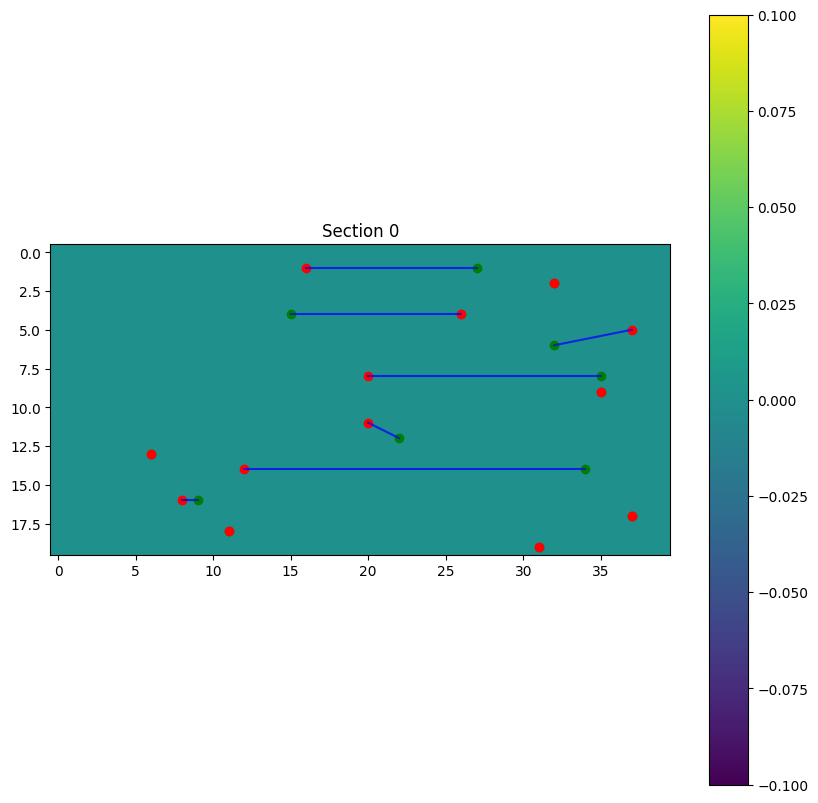

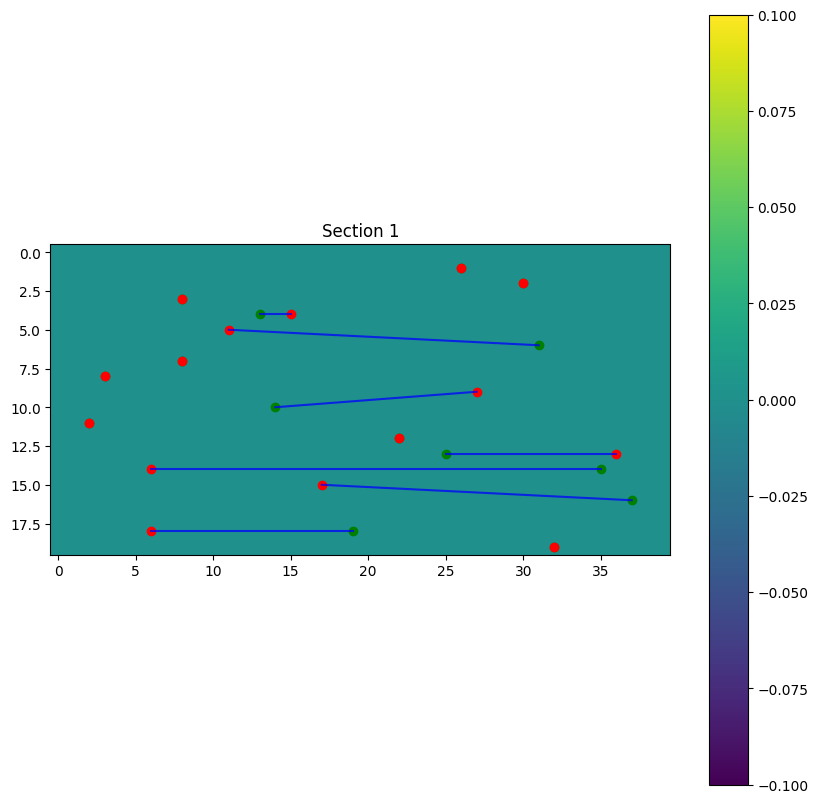

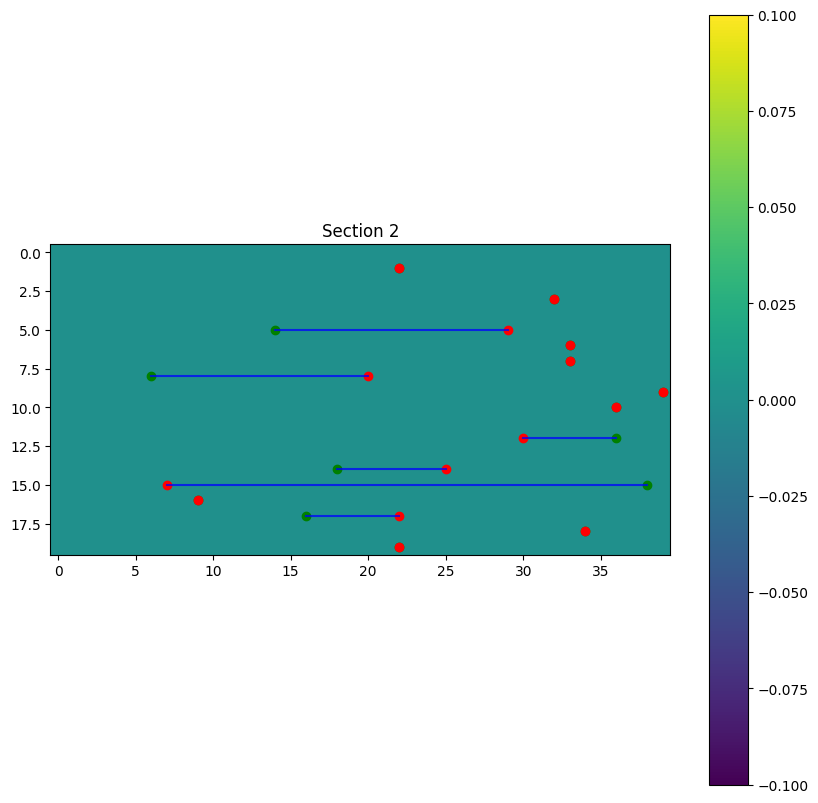

In [110]:
# Create a Laplacian matrix from the downsampled correspondence points
USE_ONE_IDX = False
# Select specific indices
if USE_ONE_IDX:
    curr_idx = 2
    curr_mpoints = mpoints[mpoints[:, 0] == curr_idx].copy()
    curr_fpoints = fpoints[fpoints[:, 0] == curr_idx].copy()
    curr_mpoints[:, 0] = 0
    curr_fpoints[:, 0] = 0
    print(curr_mpoints.shape)
    print(curr_fpoints.shape)
    fixed_sample = np.zeros((1, 20, 40))
else:
    # Use all indices
    curr_mpoints = mpoints.copy()
    curr_fpoints = fpoints.copy()
    fixed_sample = np.zeros((3, 20, 40))
deformation, A, Yd, Zd = sliceToSlice3DLaplacian(fixed_sample, curr_mpoints, curr_fpoints)
print(deformation.shape)
print("Shape of A:", A.shape)
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))

# Visualize the Jacobian determinants
jacobian_det = sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))
print("Jaocbian det shape:", jacobian_det.shape)
for i in range(jacobian_det.shape[0]):
    plt.figure(figsize=(10, 10))
    plt.imshow(jacobian_det[i] < 0, cmap='viridis')
    plt.title("Section " + str(i))
    plt.colorbar()
    
    curr_mpoints_slice = mpoints[mpoints[:, 0] == i][:, 1:]
    curr_fpoints_slice = fpoints[fpoints[:, 0] == i][:, 1:]

    plt.scatter(curr_mpoints_slice[:, 1], curr_mpoints_slice[:, 0], c='g')
    plt.scatter(curr_fpoints_slice[:, 1], curr_fpoints_slice[:, 0], c='r')
    for j in range(len(curr_mpoints_slice)):
        plt.plot([curr_mpoints_slice[j][1], curr_fpoints_slice[j][1]], 
                 [curr_mpoints_slice[j][0], curr_fpoints_slice[j][0]], color='blue', alpha=0.75)
    
    plt.show()


Loading fixed image
Loaded fixed image
fdata.shape (1, 5, 5)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Rank no of A 19
Computing dy


/tmp/ipykernel_389793/3819309635.py:189: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  dy = lgmres(A, Yd , tol = 1e-2)[0]


dx calculated in 0.9509332180023193s
Computing dx


/tmp/ipykernel_389793/3819309635.py:193: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  dz = lgmres(A, Zd, tol = 1e-2)[0]


dz calculated in 1.8382282257080078s
A shape: (25, 25)
[[ 2. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0. -1.  4. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0. -1.  4. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 

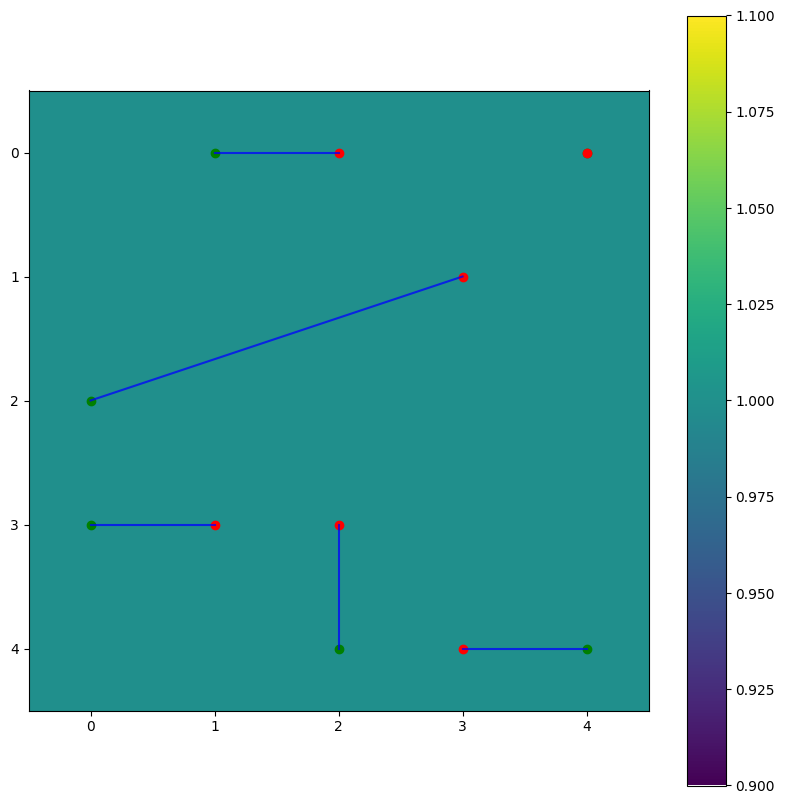

In [111]:
# Create some example correspondence points
msample = np.array([
    [0, 0, 1],
    [0, 2, 0],
    [0, 3, 0],
    [0, 4, 4],
    [0, 4, 2],
    [0, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    [0, 1, 3],
    [0, 3, 1],
    [0, 4, 3],
    [0, 3, 2],
    [0, 0, 4],
])

# Visualize the points
"""
plt.figure(figsize=(10, 10))
plt.scatter(msample[:, 2], msample[:, 1], c='g')
plt.scatter(fsample[:, 2], fsample[:, 1], c='r')
for i in range(len(msample)):
    plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='blue', alpha=0.75)
plt.gca().invert_yaxis()
plt.show()
"""

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((1, 5, 5))
deformation, A, Yd, Xd = sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Visualize values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Deformation shape:", deformation.shape)
print("Deformation:")
print(deformation)
print()

# Calculate the Jacobian determinant
jacobian_det = sitk_jacobian_determinant(deformation)
print("Minimum Jacobian determinant:", np.min(jacobian_det))
print("Maximum Jacobian determinant:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))
plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[0], cmap='viridis')
plt.colorbar()
plt.scatter(msample[:, 2], msample[:, 1], c='g')
plt.scatter(fsample[:, 2], fsample[:, 1], c='r')
for i in range(len(msample)):
    plt.plot([msample[i][2], fsample[i][2]], [msample[i][1], fsample[i][1]], color='blue', alpha=0.75)
plt.show()